# Notebook to try a more sophisticated spike detection

## Imports

In [1]:
import os 
import glob
import pickle
import pywt 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

# from matplotlib import rcParams
from mosquito.process_abf import load_processed_data

## Params

In [10]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Try it out

In [349]:
# load example data set
data_folder = 50
axo_num = 5

data = load_processed_data(data_folder, axo_num)


In [350]:
# read data 
fs = data['sampling_freq']
t = data['time']
emg = data['emg']
emg_filt = data['emg_filt']
spike_idx = data['spike_idx']

# restrict attention to less data so it goes faster
tmin = 0.0
tmax = 0.1
mask = (t >= tmin) & (t <= tmax)

time = t[mask]
chirp = emg[mask]
chirp_filt = emg_filt[mask]
spike_idx = spike_idx[(t[spike_idx] <= tmax) & (t[spike_idx] >= tmin)]

In [351]:
# try cwt (https://pywavelets.readthedocs.io/en/latest/ref/cwt.html)

wavelet = 'gaus3'
widths = np.geomspace(1, 1024, num=100)
sampling_period = 1/fs
cwtmatr, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# # visualize 
# fig, axs = plt.subplots(2, 1)
# pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
# axs[0].set_yscale("log")
# axs[0].set_xlabel("Time (s)")
# axs[0].set_ylabel("Frequency (Hz)")
# axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
# fig.colorbar(pcm, ax=axs[0])

# # plot fourier transform for comparison
# from numpy.fft import rfft, rfftfreq

# yf = rfft(chirp)
# xf = rfftfreq(len(chirp), sampling_period)
# plt.semilogx(xf, np.abs(yf))
# axs[1].set_xlabel("Frequency (Hz)")
# axs[1].set_title("Fourier Transform")
# plt.tight_layout()

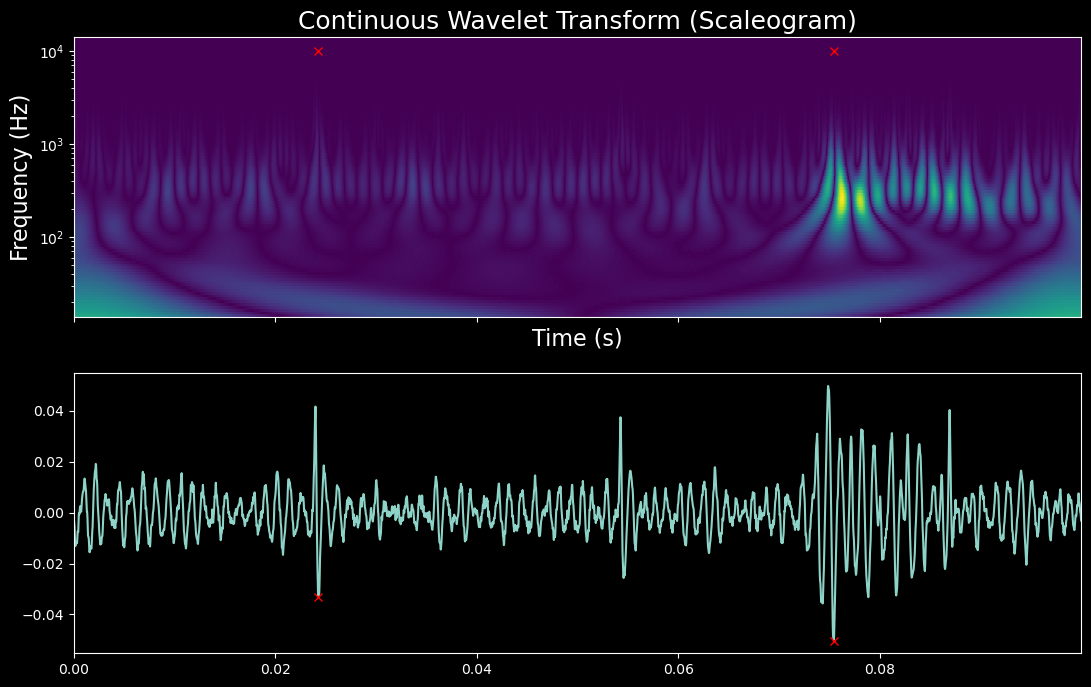

In [352]:
# just replot on bigger scale (NB: this takes forever)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(13,8), sharex=True)
pcm = ax0.pcolormesh(time, freqs, cwtmatr)
ax0.set_yscale("log")
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Frequency (Hz)")
ax0.set_title("Continuous Wavelet Transform (Scaleogram)")
# fig.colorbar(pcm, ax=ax0)

ax1.plot(time, chirp_filt)

for idx in spike_idx:
    ax0.plot(time[idx], 1e4, 'rx')
    ax1.plot(time[idx], chirp_filt[idx], 'rx')

## Try find_peaks_cwt

(0.0, 0.01)

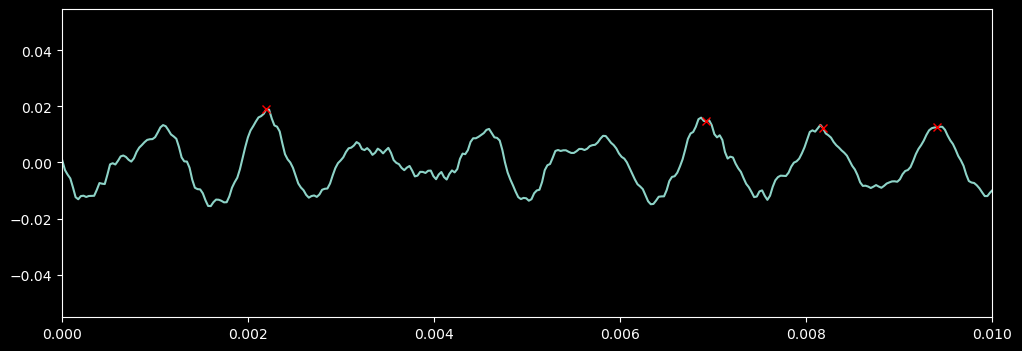

In [353]:
# try peak finding and visualize
pks = signal.find_peaks_cwt(chirp_filt, np.arange(10, 25))

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(time, chirp_filt)
ax.plot(time[pks], chirp_filt[pks], 'rx')

ax.set_xlim([0, 0.01])

In [354]:
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


## Try wavelet denoising?

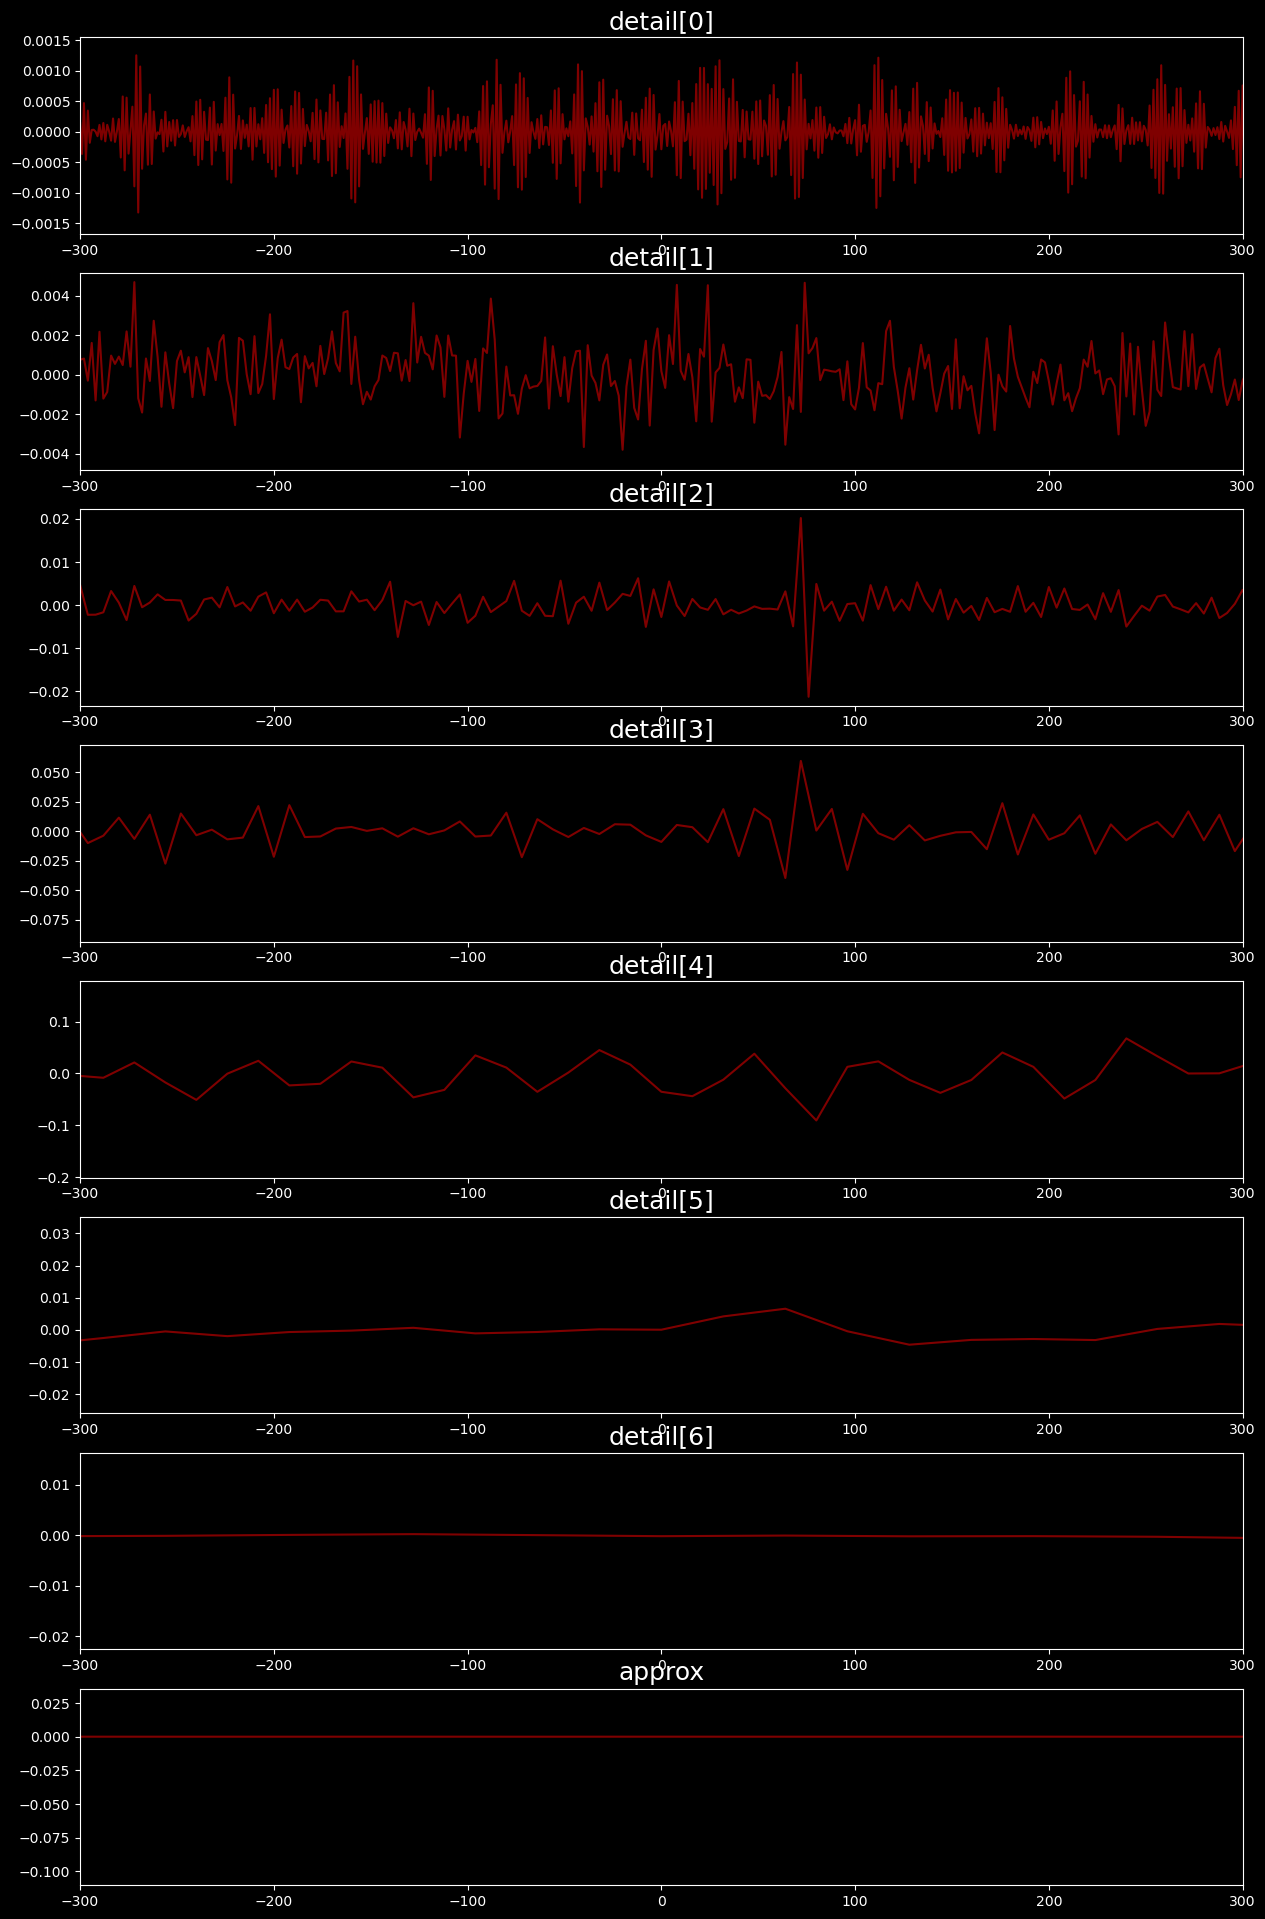

In [355]:
# just rename variables to match example
wavelet = "sym12"  # "sym12"  # "db12"
sig_dop_n2 = chirp_filt
coeffs_n = pywt.wavedec(sig_dop_n2, wavelet)  # "sym12"
approx_n = coeffs_n[0]
details_n = coeffs_n[1:]

def plot_dwt(details, approx, xlim=(-300,300), **line_kwargs):
    for i in range(len(details)):
        plt.subplot(len(details)+1,1,i+1)
        d = details[len(details)-1-i]
        half = len(d)//2
        xvals = np.arange(-half,-half+len(d))* 2**i
        plt.plot(xvals, d, **line_kwargs)
        plt.xlim(xlim)
        plt.title("detail[{}]".format(i))
    plt.subplot(len(details)+1,1,len(details)+1)
    plt.title("approx")
    plt.plot(xvals, approx, **line_kwargs)
    plt.xlim(xlim)

plt.figure(figsize=(15,24))
plot_dwt(details_n, approx_n, color="red", alpha=0.5)
plt.show()

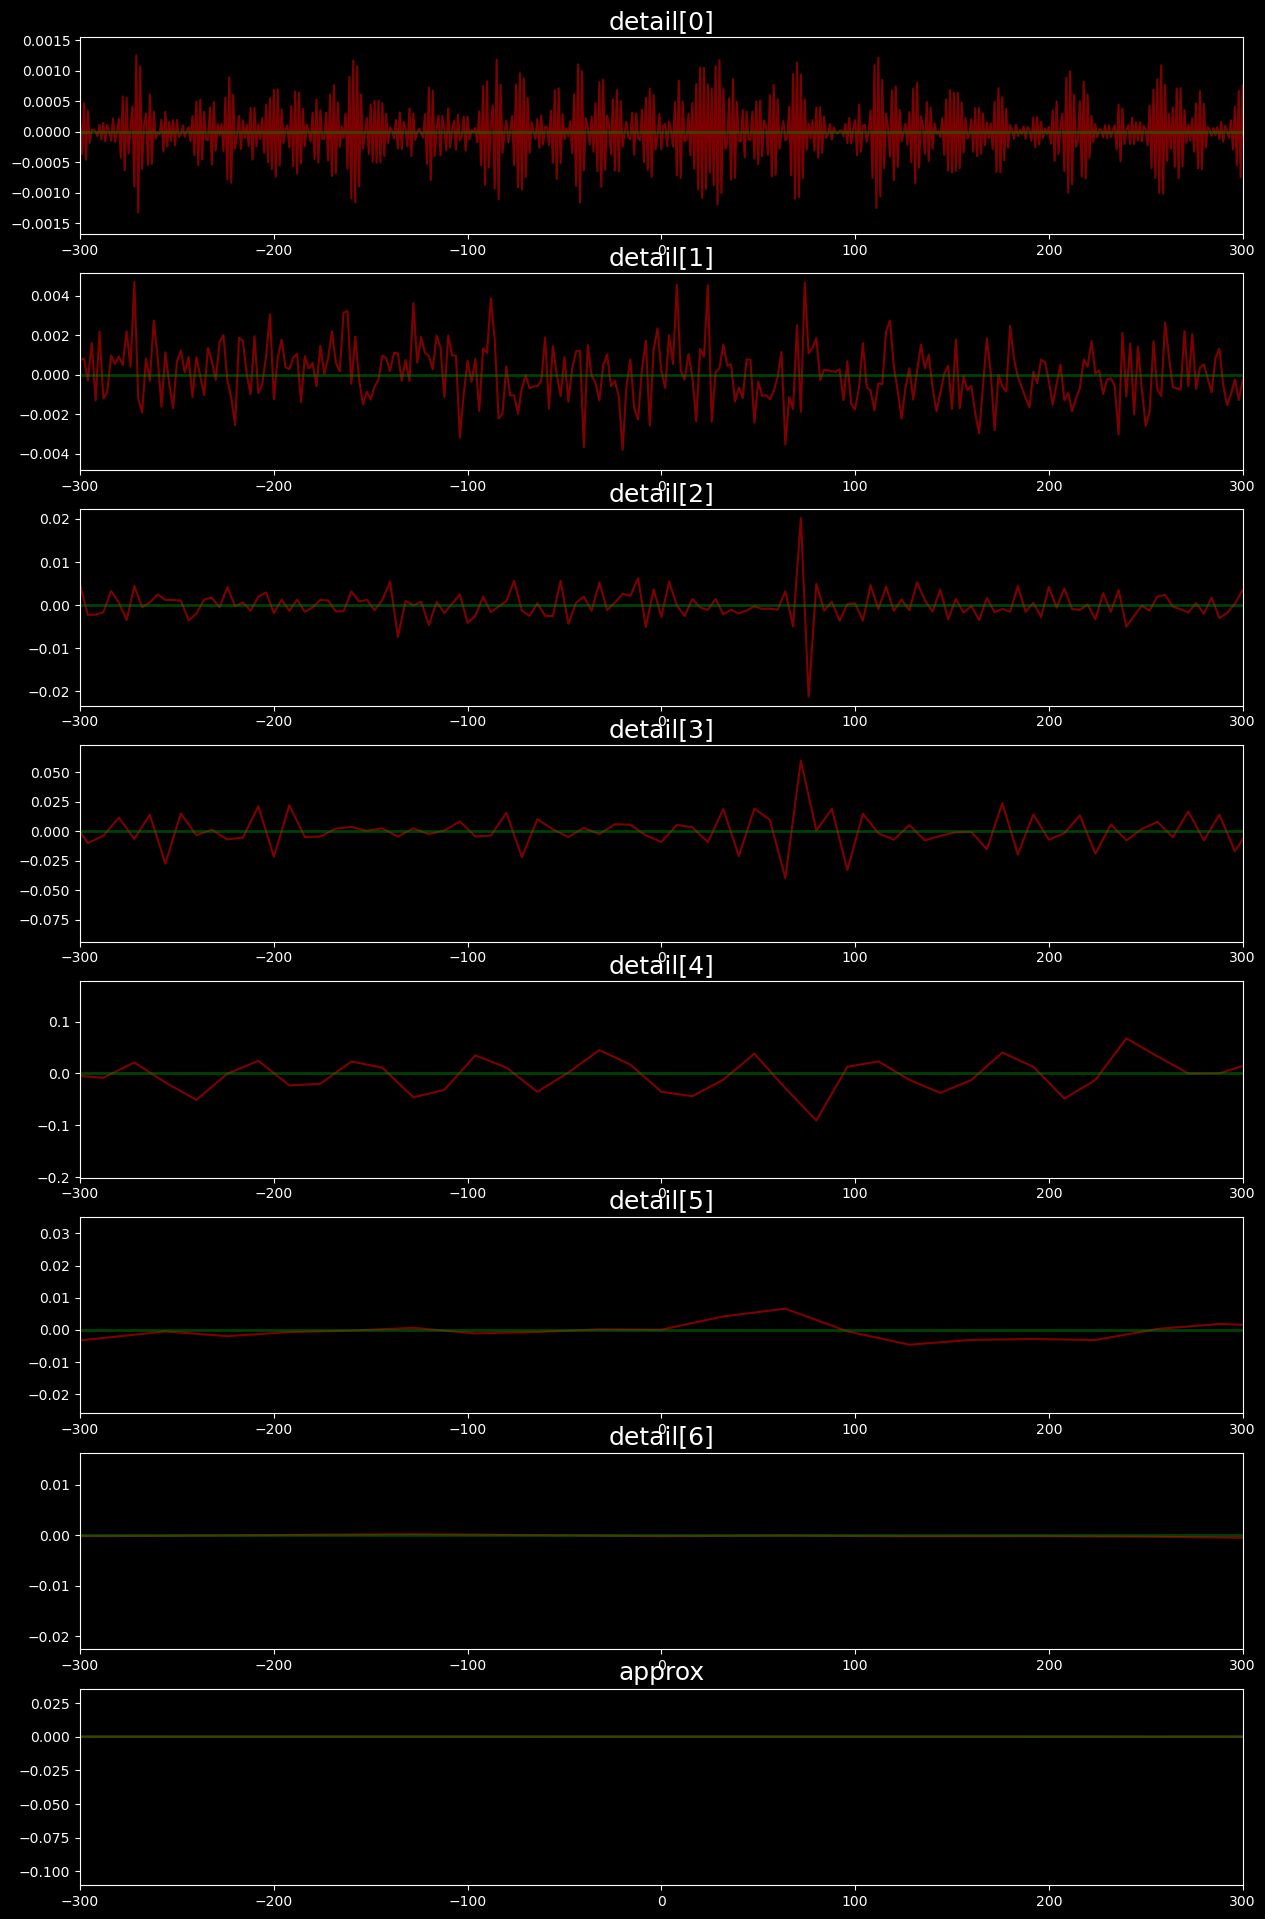

In [368]:
def neigh_block(details, n, sigma):
    res = []
    L0 = int(np.log2(n) // 2)
    L1 = max(1, L0 // 2)
    L = L0 + 2 * L1
    def nb_beta(sigma, L, detail):
        S2 = np.sum(detail ** 2)
        lmbd = 4.50524 # solution of lmbd - log(lmbd) = 3
        beta = (1 - lmbd * L * sigma**2 / S2)
        return max(0, beta)
    for d in details:
        d2 = d.copy()
        for start_b in range(0, len(d2), L0):
            end_b = min(len(d2), start_b + L0)
            start_B = start_b - L1
            end_B = start_B + L
            if start_B < 0:
                end_B -= start_B
                start_B = 0
            elif end_B > len(d2):
                start_B -= end_B - len(d2)
                end_B = len(d2)
            assert end_B - start_B == L
            d2[start_b:end_b] *= nb_beta(sigma, L, d2[start_B:end_B])
        res.append(d2)
    return res

details_nb = neigh_block(details_n, len(sig_dop_n2), 0.02)  # 0.03  # 0.02
plt.figure(figsize=(15,24))
# plot_dwt(details, approx)
plot_dwt(details_n, approx_n, color="red", alpha=0.5)
plot_dwt(details_nb, approx_n, color="green", alpha=0.5, lw=2)
plt.show()

In [369]:
# trim details
import copy
details_trim = copy.deepcopy(details_n)
for ith in range(2):
    details_trim[ith] = np.zeros_like(details_trim[ith])
    

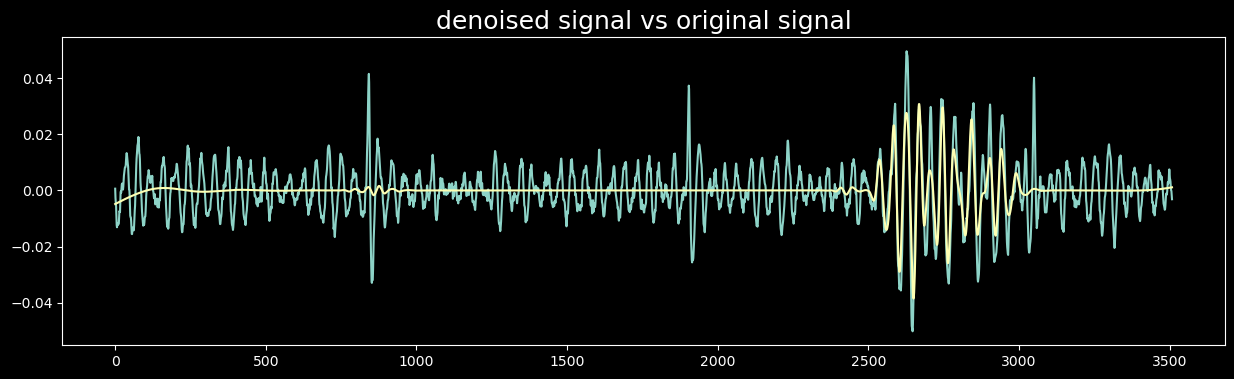

In [370]:
sig_dop_dn = pywt.waverec([approx_n] + details_nb, wavelet)
sig_dop_dn2 = pywt.waverec([approx_n] + details_trim, wavelet)
plt.figure(figsize=(15,4))
plt.title("denoised signal vs original signal")
plt.plot(sig_dop_n2)
plt.plot(sig_dop_dn[:-1])
# plt.plot(sig_dop_dn2[:-1])
#plt.plot(fsig_dop_fden)
# plt.xlim([0, 500])
plt.show()

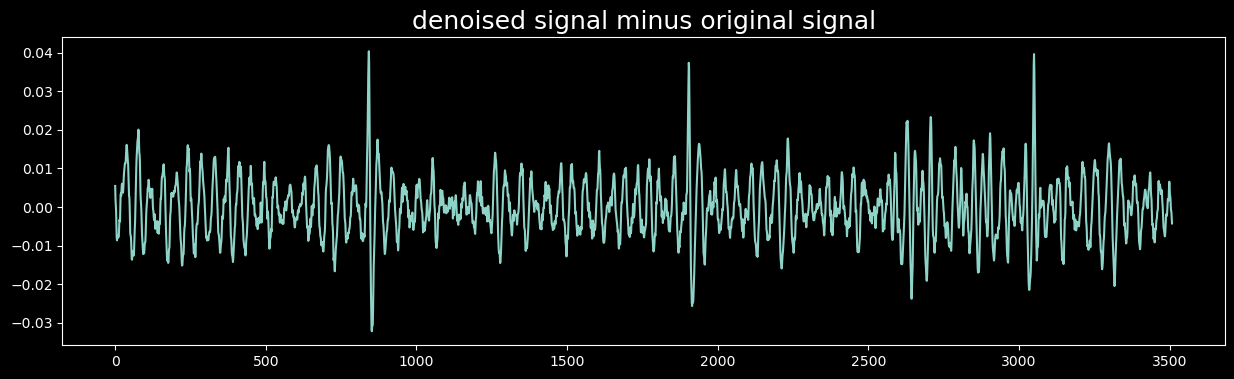

In [371]:
plt.figure(figsize=(15,4))
plt.title("denoised signal minus original signal")

plt.plot(sig_dop_n2 - sig_dop_dn[:-1])
# plt.xlim([0, 500])